<h1><center><strong><font color="black"> NLP Project : Topic 4 - Text Similarity </font></strong></center></h1>
<h1><center><font color="chillipepper"><strong>Benchmark of automatic metrics on Automatic Story Generation : 
do results depend on correlation coefficients ?</strong></font></center></h1>
<h3><center><font color="black"> Pauline Mendras - Clotilde Nietge</font></center></h3>

# Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats import pearsonr, spearmanr, kendalltau
import seaborn as sns

# Dataset : getting started

In [3]:
# Importation of datasets
df_hanna_ann = pd.read_csv("Datasets/hanna_stories_annotations.csv")
df_hanna_scores = pd.read_csv("Datasets/hanna_metric_scores.csv", index_col="Model")

In [6]:
# Useful lists 
list_criteria = ["Relevance", "Coherence", "Surprise", "Empathy", "Engagement", "Complexity"]
list_coef_corr = [pearsonr, spearmanr, kendalltau]
list_models = list(pd.unique(df_hanna_ann.Model))
list_coef_corr_label = ['Pearson', 'Spearman', 'Kendall']
list_metrics_all = list(df_hanna_scores.columns[6::])

### Visualisation of the dataset

The dataset is composed of 96 prompts. For each prompt, 11 models (10 automated and 1 human) generate a story. This story has been evaluated 3 times by a human giving a mark from 1 to 5 for 6 criteria (Relevance, Coherence, Empathy, Surprise, Egagement, Complexity).

In [7]:
df_hanna_ann.head(3)

,Story ID,Prompt,Human,Story,Model,Relevance,Coherence,Empathy,Surprise,Engagement,Complexity,Worker ID,Assignment ID,Work time in seconds,Name
0,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,4,4,3,2,4,4,A2VE5IV9OD2SK1,3X87C8JFVHIT235KQ4UTS8264I6SQJ,579.0,None
1,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,5,5,1,3,4,1,A1IZ4NX41GKU4X,3DR23U6WEGL5K0SU6D4J8W9EM9LTE7,82.0,none
2,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...","3,000 years have I been fighting. Every mornin...",Human,2,2,3,2,2,3,A264NN7JBX4UDQ,3UJ1CZ6IZSW49HMM6C6QUX7F7UV5SA,273.0,none


In [9]:
# For each criteria, compute le average of the human evaluation for each prompt/model
# in order to have only one row for each combination of Prompt/Model
df_hanna_ann_avg = df_hanna_ann.groupby(["Story ID", "Prompt", "Human", "Model", "Story"])[list_criteria].mean().reset_index()
df_hanna_ann_avg.head(4)

,Story ID,Prompt,Human,Model,Story,Relevance,Coherence,Surprise,Empathy,Engagement,Complexity
0,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...",Human,"3,000 years have I been fighting. Every mornin...",3.666667,3.666667,2.333333,2.333333,3.333333,2.666667
1,1,A new law is enacted that erases soldiers memo...,"“Dad, you 're on TV again !” I heard Eric 's v...",Human,"“Dad, you 're on TV again !” I heard Eric 's v...",5.000000,4.666667,3.666667,4.000000,3.666667,4.000000
2,2,A scientific study proves that all humans have...,"When Tyler entered the ward, his daughter Vale...",Human,"When Tyler entered the ward, his daughter Vale...",4.666667,4.666667,4.333333,4.000000,4.000000,4.333333
3,3,Write a story about an elderly wizard and his ...,His body was failing. He had taken care of it ...,Human,His body was failing. He had taken care of it ...,3.666667,4.000000,2.000000,3.000000,3.666667,4.000000


### Add the metrics to the main dataset

In [47]:
def add_metrics(data_metrics, metrics, model) :
    new_col = []
    temp = data_metrics[metrics][model]
    temp = temp.replace('[', '')
    temp = temp.replace(']', '')
    temp = temp.replace(',', '')
    temp2 = temp.split()
    for elem in temp2 :
        new_col.append(float(elem))
    new_df_metrics = pd.DataFrame(new_col)
    new_df_metrics.columns = [metrics]
    return(new_df_metrics)

In [49]:
def concat_model(data, data_metrics, metrics, list_models = list(pd.unique(df_hanna_ann_avg.Model))) :
    new_df_ = pd.DataFrame(add_metrics(data_metrics, metrics, list_models[0]))
    for model in list_models[1::] : 
        new_df = add_metrics(df_hanna_scores, metrics, model)
        new_df_ = pd.concat([new_df_, new_df])
    new_df_ = new_df_.set_index(np.arange(0, new_df_.shape[0]))
    data = data.merge(new_df_, how = 'left', left_index=True, right_index=True)
    return(data)

In [50]:
list_metrics_used

['BLEU Ξ§',
 'ROUGE-1 Recall Ξ§',
 'METEOR Ξ§',
 'chrF Ξ§',
 'ROUGE-WE-3 Recall Ξε',
 'BERTScore Recall Ξε',
 'MoverScore Ξε',
 'DepthScore Ξε',
 'BaryScore-W Ξε',
 'S3-Pyramid ΞΔ',
 'SummaQA ΞΔ',
 'InfoLM-FisherRao ΞΔ',
 'BARTScore-SH ΞΔ',
 'Coverage ¤§',
 'Repetition-1 ¤§',
 'SUPERT-PS ¤ε',
 'BLANC-Tune-PS ¤Δ']

In [51]:
concat_model(df_hanna_ann_avg, df_hanna_scores, 'BLEU Ξ§', list_models = list(pd.unique(df_hanna_ann_avg.Model)))

,Story ID,Prompt,Human,Model,Story,Relevance,Coherence,Surprise,Empathy,Engagement,...,Repetition-3 ¤§_y,SUPERT-PS ¤ε_y,SUPERT-SS ¤ε_y,BLANC-Tune-PS ¤Δ_y,BLANC-Help-PS ¤Δ_y,BLANC-Tune-SS ¤Δ_y,BLANC-Help-SS ¤Δ_y,BARTScore-PS ¤Δ_y,BARTScore-SP ¤Δ_y,BLEU Ξ§
0,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...",Human,"3,000 years have I been fighting. Every mornin...",3.666667,3.666667,2.333333,2.333333,3.333333,...,0.029289,0.360606,0.351396,0.000000,-0.026087,0.058824,-0.235294,-4.046356,-4.624497,100.000000
1,1,A new law is enacted that erases soldiers memo...,"“Dad, you 're on TV again !” I heard Eric 's v...",Human,"“Dad, you 're on TV again !” I heard Eric 's v...",5.000000,4.666667,3.666667,4.000000,3.666667,...,0.036913,0.305898,0.329835,0.040984,0.000000,-0.142857,-0.142857,-4.839603,-6.575281,100.000000
2,2,A scientific study proves that all humans have...,"When Tyler entered the ward, his daughter Vale...",Human,"When Tyler entered the ward, his daughter Vale...",4.666667,4.666667,4.333333,4.000000,4.000000,...,0.020675,0.235848,0.273803,-0.011111,-0.011111,0.031250,0.000000,-4.854327,-4.772851,100.000000
3,3,Write a story about an elderly wizard and his ...,His body was failing. He had taken care of it ...,Human,His body was failing. He had taken care of it ...,3.666667,4.000000,2.000000,3.000000,3.666667,...,0.013845,0.253024,0.245976,-0.002193,0.010965,0.125000,0.000000,-6.117441,-5.537744,100.000000
4,4,"You have become death, destroyer of worlds.","I saw the button. It was simple, red, no words...",Human,"I saw the button. It was simple, red, no words...",4.666667,5.000000,4.666667,3.000000,3.666667,...,0.011299,0.357535,0.357535,0.022472,-0.022472,0.600000,0.600000,-5.082365,-4.840554,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,1051,All you hear is a dripping noise.,All I hear is a dripping noise. At first it wa...,TD-VAE,"' I want no more.' she cried, tossing her cloa...",1.000000,2.666667,2.333333,2.000000,2.333333,...,0.001318,0.129021,0.138815,-0.003067,-0.027607,0.000000,0.000000,-5.673419,-6.898654,0.391973
1052,1052,Google search engine always was alive. They re...,86388: *what am i* 86389: They ask me question...,TD-VAE,'it says. 'it repeats in every language the wo...,2.333333,2.333333,1.333333,1.333333,2.000000,...,0.010753,0.252419,0.239887,0.000000,-0.019231,0.000000,0.000000,-5.116093,-5.711975,1.620128
1053,1053,Heart of Eden,"If everything went perfectly right, her creati...",TD-VAE,opens almost a month after the start of Star T...,2.000000,3.666667,3.000000,2.333333,3.000000,...,0.017857,0.124526,0.165431,0.000000,-0.032520,0.000000,0.000000,-5.513528,-9.977611,1.308717
1054,1054,"When a new president is elected, they are give...",“Mr President I want you to know I am telling ...,TD-VAE,'said a puppet'President Bush stopped the old ...,3.000000,2.333333,2.666667,1.666667,1.666667,...,0.026119,0.293137,0.276365,-0.013986,-0.006993,-0.037037,0.074074,-5.681099,-4.978225,1.482969


In [55]:
for metric in list_metrics_all :
    df_hanna_ann_avg = concat_model(df_hanna_ann_avg, df_hanna_scores, metric, list_models = list(pd.unique(df_hanna_ann_avg.Model)))
df_hanna_ann_avg.head(4)

,Story ID,Prompt,Human,Model,Story,Relevance,Coherence,Surprise,Empathy,Engagement,...,Repetition-2 ¤§,Repetition-3 ¤§,SUPERT-PS ¤ε,SUPERT-SS ¤ε,BLANC-Tune-PS ¤Δ,BLANC-Help-PS ¤Δ,BLANC-Tune-SS ¤Δ,BLANC-Help-SS ¤Δ,BARTScore-PS ¤Δ,BARTScore-SP ¤Δ
0,0,When you die the afterlife is an arena where y...,"3,000 years have I been fighting. Every mornin...",Human,"3,000 years have I been fighting. Every mornin...",3.666667,3.666667,2.333333,2.333333,3.333333,...,0.104072,0.029289,0.360606,0.351396,0.000000,-0.026087,0.058824,-0.235294,-4.046356,-4.624497
1,1,A new law is enacted that erases soldiers memo...,"“Dad, you 're on TV again !” I heard Eric 's v...",Human,"“Dad, you 're on TV again !” I heard Eric 's v...",5.000000,4.666667,3.666667,4.000000,3.666667,...,0.119850,0.036913,0.305898,0.329835,0.040984,0.000000,-0.142857,-0.142857,-4.839603,-6.575281
2,2,A scientific study proves that all humans have...,"When Tyler entered the ward, his daughter Vale...",Human,"When Tyler entered the ward, his daughter Vale...",4.666667,4.666667,4.333333,4.000000,4.000000,...,0.070659,0.020675,0.235848,0.273803,-0.011111,-0.011111,0.031250,0.000000,-4.854327,-4.772851
3,3,Write a story about an elderly wizard and his ...,His body was failing. He had taken care of it ...,Human,His body was failing. He had taken care of it ...,3.666667,4.000000,2.000000,3.000000,3.666667,...,0.073027,0.013845,0.253024,0.245976,-0.002193,0.010965,0.125000,0.000000,-6.117441,-5.537744


## Visualisation

Here are the performance of each system of ASG according to 6 criteria judged by humans : 

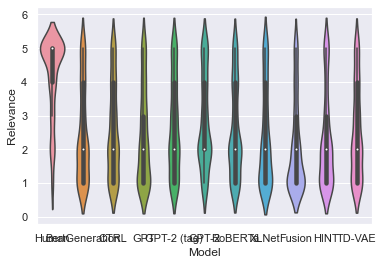

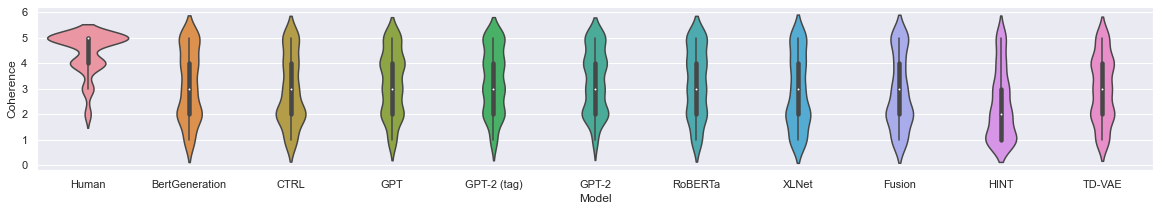

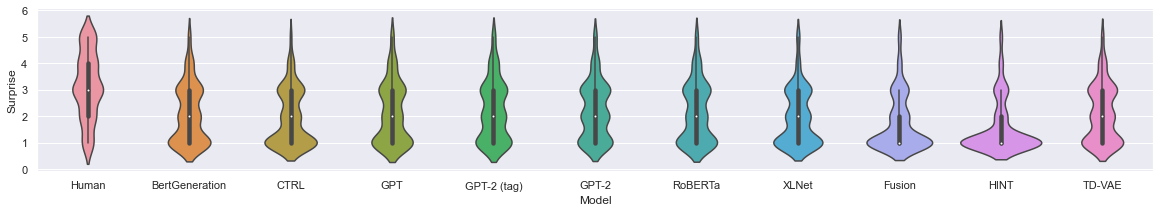

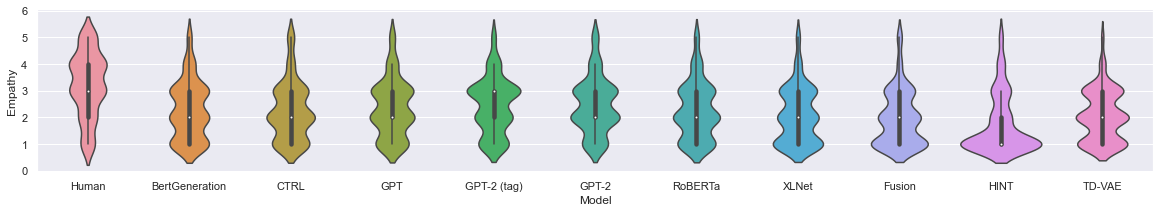

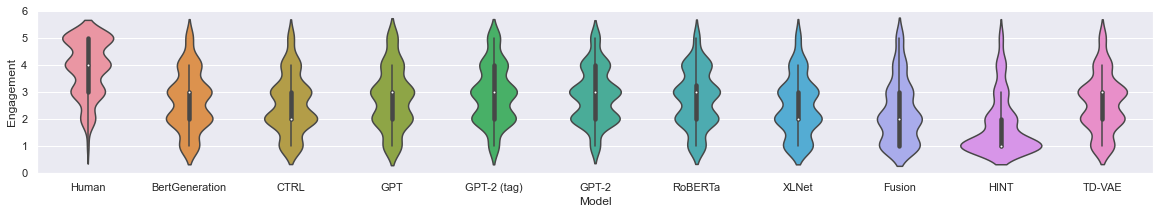

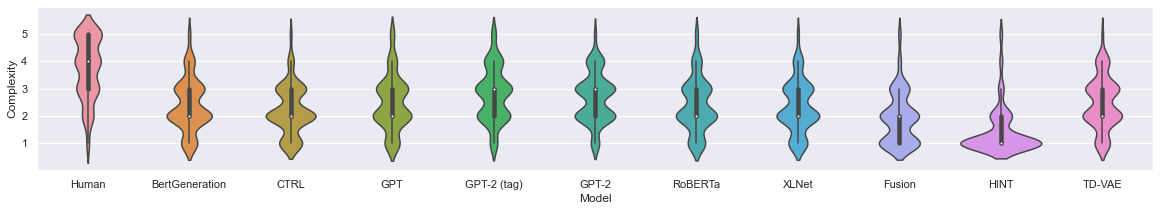

In [16]:
for criterion in list_criteria:
    sns.set(rc={"figure.figsize":(20, 3)})
    ax = sns.violinplot(x="Model", y=criterion, data=df_hanna_ann)
    plt.show()

# Correlations

It is important to skip outliers (human model)

In [56]:
df_scores_no_human = df_hanna_ann_avg[~(df_hanna_ann_avg['Model'] == 'Human')]

## Text-level correlation

In [58]:
def text_level_correlation(coef_corr, coef_corr_label, metric1, metric2, data, to_print = False):
    K = []
    for prompt in list(pd.unique(data.Prompt)) : 
        data_prompt = data[data['Prompt'] == prompt]
        m1 = list(data_prompt[metric1].values)
        m2 = list(data_prompt[metric2].values)
    
        K.append(coef_corr(m1, m2)[0])
    if to_print :
        print("Coef {} between {} and {} : \n {} ".format(coef_corr_label, metric1, metric2, np.mean(K)))
    return(np.mean(K))

## System Level

In [59]:
def system_level_correlation(coef_corr, coef_corr_label, metric1, metric2, data, to_print = False):
    """return the system-level correlation between metric1 and metric2"""
    data_model = data.groupby('Model').agg({metric1 : 'mean', metric2 : 'mean'}).reset_index()
    m1 = list(data_model[metric1].values)
    m2 = list(data_model[metric2].values)
    
    K = coef_corr(m1, m2)[0]
    if to_print :
        print("Coef {} between {} and {} : \n {} ".format(coef_corr_label, metric1, metric2, K))
    return(K)

## Correlation DataFrame

In [60]:
def get_correlation(correlation_type, coef_corr, coef_corr_label, metric1, metric2, data = df_scores_no_human):
    """return the system- or story- level correlation between metric1 and metric2"""
    if correlation_type == "system":
        return system_level_correlation(coef_corr, coef_corr_label, metric1, metric2, data = df_scores_no_human)
    elif correlation_type == "text":
        return text_level_correlation(coef_corr, coef_corr_label, metric1, metric2, data = df_scores_no_human)
    else:
        raise ValueError()

In [61]:
list_metrics_used = ["BLEU Ξ§", "ROUGE-1 Recall Ξ§",
    "METEOR Ξ§", "chrF Ξ§", "ROUGE-WE-3 Recall Ξε", "BERTScore Recall Ξε",
    "MoverScore Ξε", "DepthScore Ξε", "BaryScore-W Ξε", "S3-Pyramid ΞΔ", "SummaQA ΞΔ", 
    "InfoLM-FisherRao ΞΔ", "BARTScore-SH ΞΔ",
    "Coverage ¤§", "Repetition-1 ¤§",
    "SUPERT-PS ¤ε", "BLANC-Tune-PS ¤Δ"]

In [62]:
def correlation_df(correlation_type, coef_corr, coef_corr_label, data=df_scores_no_human, list_metrics=list_metrics_used, list_criteria=list_criteria):
    data = pd.DataFrame(np.ones((len(list_criteria), 1)))
    data['Criteria'] = list_criteria
    data = data.set_index('Criteria')
    for metric in list_metrics :
        corr_metric = []
        for criteria in list_criteria :
            K = get_correlation(correlation_type, coef_corr, coef_corr_label, metric, criteria, data = data)
            corr_metric.append(K)
        data[metric] = corr_metric
    data = data.drop(data.columns[0], axis = 1)
            
    return(data)

In [63]:
correlation_df("system", kendalltau, "kendall", data=df_scores_no_human, list_metrics=list_metrics_used, list_criteria=list_criteria)

,BLEU Ξ§,ROUGE-1 Recall Ξ§,METEOR Ξ§,chrF Ξ§,ROUGE-WE-3 Recall Ξε,BERTScore Recall Ξε,MoverScore Ξε,DepthScore Ξε,BaryScore-W Ξε,S3-Pyramid ΞΔ,SummaQA ΞΔ,InfoLM-FisherRao ΞΔ,BARTScore-SH ΞΔ,Coverage ¤§,Repetition-1 ¤§,SUPERT-PS ¤ε,BLANC-Tune-PS ¤Δ
Criteria,,,,,,,,,,,,,,,,,
Relevance,0.555556,0.511111,0.555556,0.600000,0.555556,0.555556,0.600000,-0.422222,-0.555556,0.600000,0.333333,-0.511111,0.511111,-0.333333,-0.288889,0.111111,0.244444
Coherence,0.333333,0.377778,0.422222,0.466667,0.333333,0.422222,0.555556,-0.466667,-0.511111,0.377778,0.200000,-0.200000,0.555556,-0.377778,-0.244444,-0.200000,-0.155556
Surprise,0.422222,0.466667,0.511111,0.555556,0.422222,0.511111,0.466667,-0.555556,-0.511111,0.466667,0.288889,-0.200000,0.555556,-0.377778,-0.244444,-0.200000,-0.155556
Empathy,0.422222,0.466667,0.422222,0.466667,0.422222,0.511111,0.733333,-0.555556,-0.688889,0.377778,0.200000,-0.377778,0.555556,-0.200000,-0.155556,-0.022222,0.022222
Engagement,0.333333,0.377778,0.422222,0.466667,0.333333,0.422222,0.555556,-0.466667,-0.511111,0.377778,0.200000,-0.200000,0.555556,-0.377778,-0.244444,-0.200000,-0.155556
Complexity,0.522862,0.568329,0.613795,0.659261,0.522862,0.613795,0.431930,-0.659261,-0.477396,0.568329,0.386463,-0.295531,0.659261,-0.431930,-0.295531,-0.204598,-0.068199


In [64]:
correlation_df("text", kendalltau, "kendall", data=df_scores_no_human, list_metrics=list_metrics_used, list_criteria=list_criteria)

,BLEU Ξ§,ROUGE-1 Recall Ξ§,METEOR Ξ§,chrF Ξ§,ROUGE-WE-3 Recall Ξε,BERTScore Recall Ξε,MoverScore Ξε,DepthScore Ξε,BaryScore-W Ξε,S3-Pyramid ΞΔ,SummaQA ΞΔ,InfoLM-FisherRao ΞΔ,BARTScore-SH ΞΔ,Coverage ¤§,Repetition-1 ¤§,SUPERT-PS ¤ε,BLANC-Tune-PS ¤Δ
Criteria,,,,,,,,,,,,,,,,,
Relevance,0.139220,0.147133,0.134928,0.156322,0.148474,0.162014,0.191197,-0.091055,-0.144801,0.150792,NaN,-0.115369,0.223228,0.062816,-0.074640,0.285919,0.079489
Coherence,0.170694,0.234594,0.215247,0.246078,0.252900,0.225319,0.214340,-0.216396,-0.202414,0.243946,NaN,-0.121323,0.250612,-0.035482,-0.164872,0.041689,0.007105
Surprise,0.173077,0.236715,0.216725,0.244503,0.216367,0.212542,0.181265,-0.176798,-0.167861,0.227996,NaN,-0.109668,0.200449,-0.076749,-0.174292,0.014309,0.004158
Empathy,0.184805,0.226875,0.219440,0.233341,0.235801,0.217530,0.179976,-0.163974,-0.191190,0.231939,NaN,-0.109529,0.223250,-0.073417,-0.064379,0.029098,-0.003959
Engagement,0.227637,0.291930,0.280325,0.307714,0.273590,0.289336,0.250907,-0.228623,-0.250026,0.296217,NaN,-0.141950,0.280954,-0.049064,-0.180257,0.053888,-0.038938
Complexity,0.302006,0.406543,0.391972,0.433072,0.386217,0.380209,0.282973,-0.286734,-0.281079,0.391124,NaN,-0.184391,0.333800,-0.063225,-0.235052,0.053521,0.003732


In [65]:
correlation_df("system", pearsonr, "pearson", data=df_scores_no_human, list_metrics=list_metrics_used, list_criteria=list_criteria)

,BLEU Ξ§,ROUGE-1 Recall Ξ§,METEOR Ξ§,chrF Ξ§,ROUGE-WE-3 Recall Ξε,BERTScore Recall Ξε,MoverScore Ξε,DepthScore Ξε,BaryScore-W Ξε,S3-Pyramid ΞΔ,SummaQA ΞΔ,InfoLM-FisherRao ΞΔ,BARTScore-SH ΞΔ,Coverage ¤§,Repetition-1 ¤§,SUPERT-PS ¤ε,BLANC-Tune-PS ¤Δ
Criteria,,,,,,,,,,,,,,,,,
Relevance,0.798877,0.790972,0.776319,0.762958,0.753594,0.733719,0.673212,-0.670676,-0.650863,0.789947,0.716075,-0.607642,0.776243,-0.396191,-0.500028,0.290330,-0.111143
Coherence,0.738506,0.735252,0.719461,0.745555,0.780340,0.836491,0.869488,-0.873827,-0.879879,0.774057,0.570609,-0.660988,0.864701,-0.736499,-0.783498,-0.454586,-0.750157
Surprise,0.805086,0.841146,0.831991,0.873878,0.824351,0.910923,0.888746,-0.907123,-0.845573,0.860580,0.769825,-0.697924,0.926483,-0.729530,-0.843661,-0.251919,-0.621568
Empathy,0.773016,0.745916,0.725024,0.736863,0.809636,0.827221,0.861684,-0.861967,-0.899616,0.788340,0.610461,-0.727534,0.878312,-0.634484,-0.682967,-0.272418,-0.606669
Engagement,0.812584,0.817247,0.807437,0.832873,0.843066,0.908170,0.920706,-0.934389,-0.911444,0.848558,0.699043,-0.759186,0.924440,-0.780298,-0.839974,-0.400835,-0.740132
Complexity,0.868328,0.904891,0.897045,0.924549,0.903020,0.954887,0.903852,-0.956274,-0.881906,0.924822,0.801520,-0.754682,0.938346,-0.748309,-0.827365,-0.329182,-0.681254


In [66]:
correlation_df("system", spearmanr, "spearman", data=df_scores_no_human, list_metrics=list_metrics_used, list_criteria=list_criteria)

,BLEU Ξ§,ROUGE-1 Recall Ξ§,METEOR Ξ§,chrF Ξ§,ROUGE-WE-3 Recall Ξε,BERTScore Recall Ξε,MoverScore Ξε,DepthScore Ξε,BaryScore-W Ξε,S3-Pyramid ΞΔ,SummaQA ΞΔ,InfoLM-FisherRao ΞΔ,BARTScore-SH ΞΔ,Coverage ¤§,Repetition-1 ¤§,SUPERT-PS ¤ε,BLANC-Tune-PS ¤Δ
Criteria,,,,,,,,,,,,,,,,,
Relevance,0.721212,0.696970,0.733333,0.745455,0.721212,0.709091,0.781818,-0.612121,-0.709091,0.757576,0.442424,-0.648485,0.696970,-0.539394,-0.393939,0.163636,0.296970
Coherence,0.575758,0.600000,0.624242,0.660606,0.575758,0.636364,0.709091,-0.660606,-0.696970,0.600000,0.272727,-0.357576,0.684848,-0.490909,-0.369697,-0.187879,-0.103030
Surprise,0.624242,0.648485,0.672727,0.721212,0.624242,0.696970,0.624242,-0.721212,-0.684848,0.648485,0.357576,-0.345455,0.684848,-0.466667,-0.369697,-0.212121,-0.127273
Empathy,0.600000,0.624242,0.612121,0.624242,0.600000,0.636364,0.818182,-0.684848,-0.806061,0.587879,0.272727,-0.466667,0.721212,-0.321212,-0.260606,-0.006061,-0.018182
Engagement,0.575758,0.600000,0.624242,0.660606,0.575758,0.636364,0.709091,-0.660606,-0.696970,0.600000,0.272727,-0.357576,0.684848,-0.490909,-0.369697,-0.187879,-0.103030
Complexity,0.695135,0.725623,0.768307,0.798795,0.695135,0.756112,0.567084,-0.804893,-0.652451,0.737819,0.493912,-0.396349,0.786600,-0.530498,-0.396349,-0.225614,-0.079270


## Normalization of human judgements

In [268]:
def normalization(data, criteria) : 
    criteria_norm = criteria + '_norm'
    data[criteria_norm] = (data[criteria] - data[criteria].mean())/(data[criteria].std())

In [269]:
for criteria in list_criteria :
    normalization(df_scores_no_human, criteria)

/Users/cloclo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [272]:
list_criteria_norm = [x + '_norm' for x in list_criteria]
correlation_df("system", kendalltau, "kendall", data=df_scores_no_human, list_metrics=list_metrics_used, list_criteria=list_criteria_norm)

,BLEU Ξ§,ROUGE-1 Recall Ξ§,METEOR Ξ§,chrF Ξ§,ROUGE-WE-3 Recall Ξε,BERTScore Recall Ξε,MoverScore Ξε,DepthScore Ξε,BaryScore-W Ξε,S3-Pyramid ΞΔ,SummaQA ΞΔ,InfoLM-FisherRao ΞΔ,BARTScore-SH ΞΔ,Coverage ¤§,Repetition-1 ¤§,SUPERT-PS ¤ε,BLANC-Tune-PS ¤Δ
Criteria,,,,,,,,,,,,,,,,,
Relevance_norm,0.555556,0.511111,0.555556,0.600000,0.555556,0.555556,0.600000,-0.422222,-0.555556,0.600000,0.333333,-0.511111,0.511111,-0.333333,-0.288889,0.111111,0.244444
Coherence_norm,0.333333,0.377778,0.422222,0.466667,0.333333,0.422222,0.555556,-0.466667,-0.511111,0.377778,0.200000,-0.200000,0.555556,-0.377778,-0.244444,-0.200000,-0.155556
Surprise_norm,0.422222,0.466667,0.511111,0.555556,0.422222,0.511111,0.466667,-0.555556,-0.511111,0.466667,0.288889,-0.200000,0.555556,-0.377778,-0.244444,-0.200000,-0.155556
Empathy_norm,0.422222,0.466667,0.422222,0.466667,0.422222,0.511111,0.733333,-0.555556,-0.688889,0.377778,0.200000,-0.377778,0.555556,-0.200000,-0.155556,-0.022222,0.022222
Engagement_norm,0.333333,0.377778,0.422222,0.466667,0.333333,0.422222,0.555556,-0.466667,-0.511111,0.377778,0.200000,-0.200000,0.555556,-0.377778,-0.244444,-0.200000,-0.155556
Complexity_norm,0.494413,0.539360,0.584307,0.629253,0.494413,0.584307,0.404520,-0.629253,-0.449467,0.539360,0.359573,-0.269680,0.629253,-0.449467,-0.314627,-0.224733,-0.089893


In [195]:
correlation_df("system", kendalltau, "kendall", data=df_scores_no_human, list_metrics=list_metrics, list_criteria=list_criteria)

,BLEU Ξ§,ROUGE-1 Recall Ξ§,METEOR Ξ§,chrF Ξ§,BERTScore Recall Ξε
Criteria,,,,,
Relevance,0.555556,0.511111,0.555556,0.600000,0.555556
Coherence,0.333333,0.377778,0.422222,0.466667,0.422222
Surprise,0.422222,0.466667,0.511111,0.555556,0.511111
Empathy,0.422222,0.466667,0.422222,0.466667,0.511111
Engagement,0.333333,0.377778,0.422222,0.466667,0.422222
Complexity,0.522862,0.568329,0.613795,0.659261,0.613795


## Heatmaps

In [82]:
def heatmaps_correlations(type_corr, corr_coef, corr_coef_label, data, list_metrics, list_criteria) : 
    tab_corr = (100*correlation_df(type_corr, corr_coef, corr_coef_label, data=df_scores_no_human, list_metrics=list_metrics, list_criteria=list_criteria)).round().abs()
    sns.set(font_scale=1.2)
    fig, ax = plt.subplots(figsize=(8,7))
    sns.heatmap(tab_corr.T, annot=True).set(title=corr_coef_label +  ' coefficients')

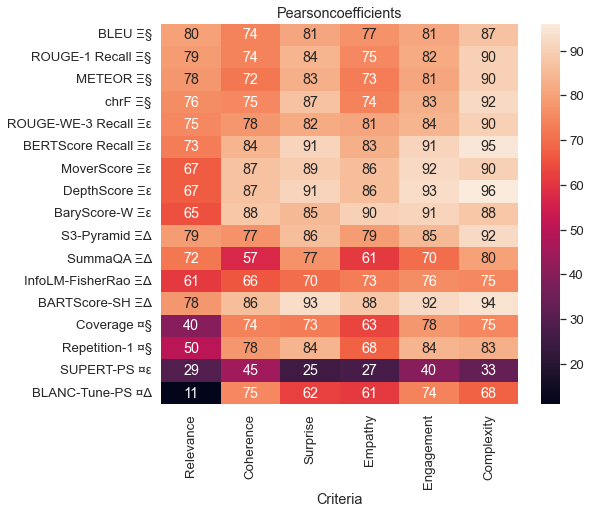

In [69]:
heatmaps_correlations('system', pearsonr, 'Pearson', data=df_scores_no_human, list_metrics=list_metrics_used, list_criteria=list_criteria)

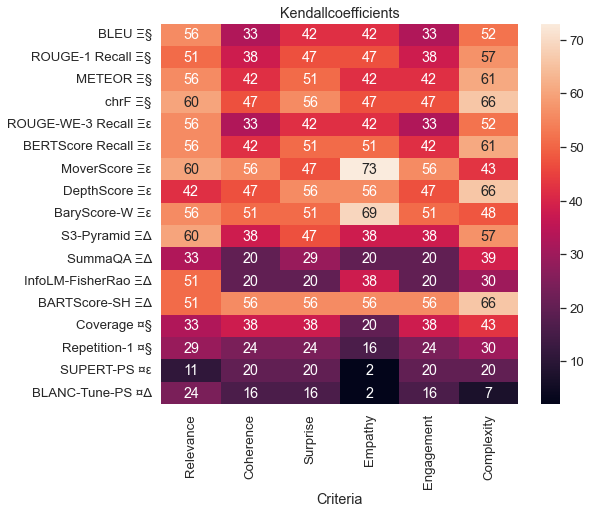

In [303]:
heatmaps_correlations('system', kendalltau, 'Kendall', data=df_scores_no_human, list_metrics=list_metrics_used, list_criteria=list_criteria)

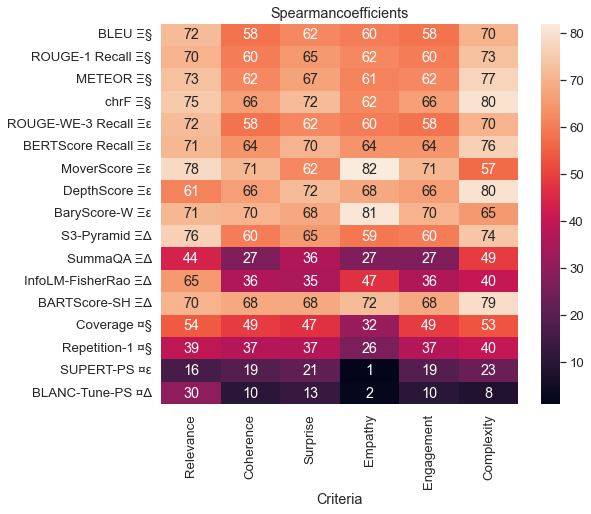

In [304]:
heatmaps_correlations('system', spearmanr, 'Spearman', data=df_scores_no_human, list_metrics=list_metrics_used, list_criteria=list_criteria)

In [74]:
list_metrics_used_text = ['BLEU Ξ§', 'ROUGE-1 Recall Ξ§', 'METEOR Ξ§',
 'chrF Ξ§', 'ROUGE-WE-3 Recall Ξε', 'BERTScore Recall Ξε', 'MoverScore Ξε', 'DepthScore Ξε',
 'BaryScore-W Ξε', 'S3-Pyramid ΞΔ', 'InfoLM-FisherRao ΞΔ', 'BARTScore-SH ΞΔ',
 'Coverage ¤§', 'Repetition-1 ¤§', 'SUPERT-PS ¤ε', 'BLANC-Tune-PS ¤Δ']

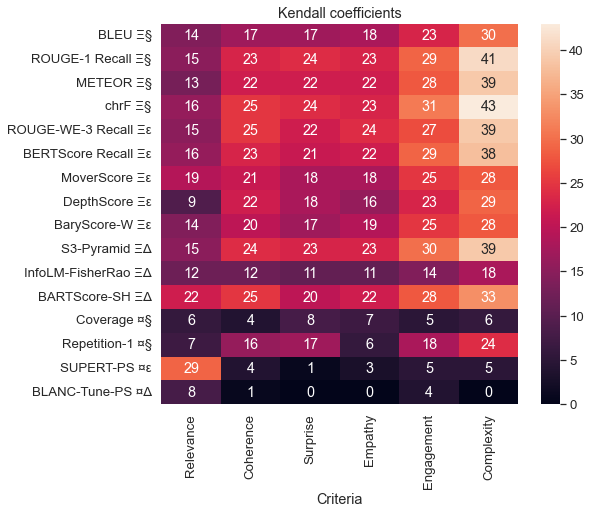

In [83]:
heatmaps_correlations('text', kendalltau, 'Kendall', data=df_scores_no_human, list_metrics=list_metrics_used_text, list_criteria=list_criteria)

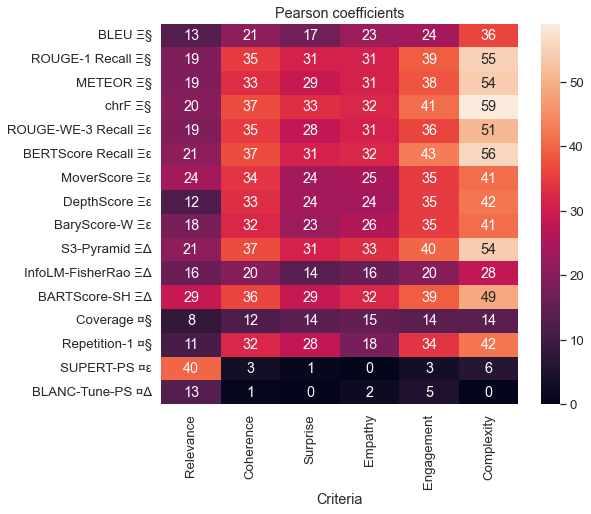

In [84]:
heatmaps_correlations('text', pearsonr, 'Pearson', data=df_scores_no_human, list_metrics=list_metrics_used_text, list_criteria=list_criteria)

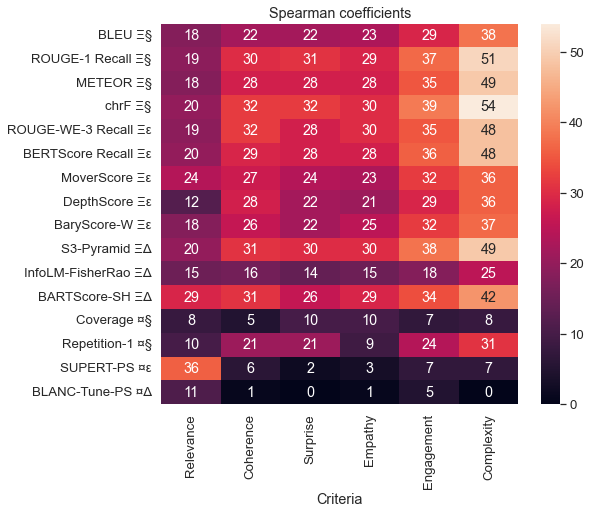

In [85]:
heatmaps_correlations('text', spearmanr, 'Spearman', data=df_scores_no_human, list_metrics=list_metrics_used_text, list_criteria=list_criteria)

## Best metrics

In [86]:
def print_best_metrics(correlation_type, coef_corr, coef_corr_label, data=df_scores_no_human, n_best=5):
    """prints the `n_best` best metrics for each criterion for the corresponding `correlation_type` and `correlation coef`"""
    corr = correlation_df(correlation_type, coef_corr, coef_corr_label, data=data, list_metrics=list_metrics_used, list_criteria=list_criteria)
    for criterion in list_criteria:
        print(criterion)
        print(corr.abs().T.sort_values(criterion, ascending=False)[criterion].head(n_best))
        print('\n')

In [87]:
print_best_metrics("system", kendalltau, "kendall")

Relevance
S3-Pyramid ΞΔ          0.600000
chrF Ξ§                0.600000
MoverScore Ξε          0.600000
BLEU Ξ§                0.555556
BERTScore Recall Ξε    0.555556
Name: Relevance, dtype: float64


Coherence
BARTScore-SH ΞΔ    0.555556
MoverScore Ξε      0.555556
BaryScore-W Ξε     0.511111
chrF Ξ§            0.466667
DepthScore Ξε      0.466667
Name: Coherence, dtype: float64


Surprise
chrF Ξ§            0.555556
BARTScore-SH ΞΔ    0.555556
DepthScore Ξε      0.555556
BaryScore-W Ξε     0.511111
METEOR Ξ§          0.511111
Name: Surprise, dtype: float64


Empathy
MoverScore Ξε          0.733333
BaryScore-W Ξε         0.688889
DepthScore Ξε          0.555556
BARTScore-SH ΞΔ        0.555556
BERTScore Recall Ξε    0.511111
Name: Empathy, dtype: float64


Engagement
BARTScore-SH ΞΔ    0.555556
MoverScore Ξε      0.555556
BaryScore-W Ξε     0.511111
chrF Ξ§            0.466667
DepthScore Ξε      0.466667
Name: Engagement, dtype: float64


Complexity
chrF Ξ§                0.659261
B

In [88]:
print_best_metrics("system", pearsonr, "pearson")

Relevance
BLEU Ξ§              0.798877
ROUGE-1 Recall Ξ§    0.790972
S3-Pyramid ΞΔ        0.789947
METEOR Ξ§            0.776319
BARTScore-SH ΞΔ      0.776243
Name: Relevance, dtype: float64


Coherence
BaryScore-W Ξε         0.879879
DepthScore Ξε          0.873827
MoverScore Ξε          0.869488
BARTScore-SH ΞΔ        0.864701
BERTScore Recall Ξε    0.836491
Name: Coherence, dtype: float64


Surprise
BARTScore-SH ΞΔ        0.926483
BERTScore Recall Ξε    0.910923
DepthScore Ξε          0.907123
MoverScore Ξε          0.888746
chrF Ξ§                0.873878
Name: Surprise, dtype: float64


Empathy
BaryScore-W Ξε         0.899616
BARTScore-SH ΞΔ        0.878312
DepthScore Ξε          0.861967
MoverScore Ξε          0.861684
BERTScore Recall Ξε    0.827221
Name: Empathy, dtype: float64


Engagement
DepthScore Ξε          0.934389
BARTScore-SH ΞΔ        0.924440
MoverScore Ξε          0.920706
BaryScore-W Ξε         0.911444
BERTScore Recall Ξε    0.908170
Name: Engagement, dtype: floa

In [89]:
print_best_metrics("system", spearmanr, "spearman")

Relevance
MoverScore Ξε    0.781818
S3-Pyramid ΞΔ    0.757576
chrF Ξ§          0.745455
METEOR Ξ§        0.733333
BLEU Ξ§          0.721212
Name: Relevance, dtype: float64


Coherence
MoverScore Ξε      0.709091
BaryScore-W Ξε     0.696970
BARTScore-SH ΞΔ    0.684848
chrF Ξ§            0.660606
DepthScore Ξε      0.660606
Name: Coherence, dtype: float64


Surprise
chrF Ξ§                0.721212
DepthScore Ξε          0.721212
BERTScore Recall Ξε    0.696970
BaryScore-W Ξε         0.684848
BARTScore-SH ΞΔ        0.684848
Name: Surprise, dtype: float64


Empathy
MoverScore Ξε          0.818182
BaryScore-W Ξε         0.806061
BARTScore-SH ΞΔ        0.721212
DepthScore Ξε          0.684848
BERTScore Recall Ξε    0.636364
Name: Empathy, dtype: float64


Engagement
MoverScore Ξε      0.709091
BaryScore-W Ξε     0.696970
BARTScore-SH ΞΔ    0.684848
chrF Ξ§            0.660606
DepthScore Ξε      0.660606
Name: Engagement, dtype: float64


Complexity
DepthScore Ξε          0.804893
chrF Ξ§    

## Wilcoxon tests

In [91]:
from scipy.stats import wilcoxon

In [92]:
corr_pearson = correlation_df('system', pearsonr, 'Pearson', data=df_scores_no_human, list_metrics=list_metrics_all, list_criteria=list_criteria)
corr_spearman = correlation_df('system', spearmanr, 'Spearman', data=df_scores_no_human, list_metrics=list_metrics_all, list_criteria=list_criteria)
corr_kendall = correlation_df('system', kendalltau, 'Kendall', data=df_scores_no_human, list_metrics=list_metrics_all, list_criteria=list_criteria)

In [93]:
criterion = 'Relevance'

rel_pearson = corr_pearson.abs().T[criterion]
rel_spearman = corr_spearman.abs().T[criterion]
rel_kendall = corr_kendall.abs().T[criterion]

diff_ps = rel_pearson - rel_spearman
diff_ks = rel_kendall - rel_spearman
diff_pk = rel_pearson - rel_kendall

print("Entre Pearson et Spearman : ")
print(wilcoxon(diff_ps).statistic, wilcoxon(diff_ps).pvalue)
print("Entre Kendall et Spearman : ")
print(wilcoxon(diff_ks).statistic, wilcoxon(diff_ks).pvalue)

Entre Pearson et Spearman : 
845.0 0.008490760986031787
Entre Kendall et Spearman : 
6.0 2.1096734364827293e-13


In [94]:
(rel_pearson - rel_spearman).reset_index()

,index,Relevance
0,BLEU Ξ§,0.077665
1,ROUGE-1 Recall Ξ§,0.094002
2,ROUGE-1 Precision Ξ§,0.143314
3,ROUGE-1 F-Score Ξ§,0.050901
4,ROUGE-2 Recall Ξ§,0.062313
...,...,...
67,BLANC-Help-PS ¤Δ,-0.057749
68,BLANC-Tune-SS ¤Δ,0.130920
69,BLANC-Help-SS ¤Δ,0.103147
70,BARTScore-PS ¤Δ,0.123368


The p-value is below 0.05. So, at the 5% level, there is a difference by taking Pearson or Spearman.

In [95]:
def wilcoxon_test(list_corr_coef, list_criteria = list_criteria):
    data = pd.DataFrame(np.ones((len(list_corr_coef), 1)))
    data['Coef_corr'] = list_corr_coef
    data = data.set_index('Coef_corr')
    for criterion in list_criteria :
        rel_pearson = corr_pearson.abs().T.sort_values(criterion, ascending=False)[criterion]
        rel_spearman = corr_spearman.abs().T.sort_values(criterion, ascending=False)[criterion]
        rel_kendall = corr_kendall.abs().T.sort_values(criterion, ascending=False)[criterion]
        
        diff_ps = (rel_pearson - rel_spearman).reset_index()[criterion]
        diff_ks = (rel_kendall - rel_spearman).reset_index()[criterion]
        diff_pk = (rel_pearson - rel_kendall).reset_index()[criterion]
        
        corr_criterion = [wilcoxon(diff_ps).statistic, wilcoxon(diff_ks).statistic, wilcoxon(diff_pk).statistic]

        
        data[criterion] = corr_criterion
    data = data.drop(data.columns[0], axis = 1)
            
    return(data)

In [96]:
wilcoxon_test(['Pearson/Spearman', 'Kendall/Spearman', 'Kendall/Pearson'], list_criteria = list_criteria)

,Relevance,Coherence,Surprise,Empathy,Engagement,Complexity
Coef_corr,,,,,,
Pearson/Spearman,845.0,335.0,256.0,319.0,248.0,254.0
Kendall/Spearman,6.0,41.0,9.0,48.0,41.0,1.0
Kendall/Pearson,86.0,90.0,43.0,103.0,60.0,49.0


In [97]:
for criterion in list_criteria:
    print("Pour le critère : " + criterion)
    rel_pearson = corr_pearson.abs().T[criterion]
    rel_spearman = corr_spearman.abs().T[criterion]
    rel_kendall = corr_kendall.abs().T[criterion]

    diff_ps = rel_pearson - rel_spearman
    diff_ks = rel_kendall - rel_spearman
    diff_pk = rel_pearson - rel_kendall

    print("Entre Pearson et Spearman : ")
    print(wilcoxon(diff_ps).statistic, wilcoxon(diff_ps).pvalue)
    print("Entre Kendall et Spearman : ")
    print(wilcoxon(diff_ks).statistic, wilcoxon(diff_ks).pvalue)
    print("Entre Pearson et Kendall : ")
    print(wilcoxon(diff_pk).statistic, wilcoxon(diff_pk).pvalue)
    print('\n')

Pour le critère : Relevance
Entre Pearson et Spearman : 
845.0 0.008490760986031787
Entre Kendall et Spearman : 
6.0 2.1096734364827293e-13
Entre Pearson et Kendall : 
86.0 5.531830389987057e-12


Pour le critère : Coherence
Entre Pearson et Spearman : 
335.0 3.9317282765969774e-08
Entre Kendall et Spearman : 
41.0 8.99354790742241e-13
Entre Pearson et Kendall : 
90.0 6.4759220833613215e-12


Pour le critère : Surprise
Entre Pearson et Spearman : 
256.0 2.8989829182947345e-09
Entre Kendall et Spearman : 
9.0 2.4002343697670414e-13
Entre Pearson et Kendall : 
43.0 9.85487748665146e-13


Pour le critère : Empathy
Entre Pearson et Spearman : 
319.0 2.3548320062068592e-08
Entre Kendall et Spearman : 
48.0 1.2030574690344099e-12
Entre Pearson et Kendall : 
103.0 1.0770242751016968e-11


Pour le critère : Engagement
Entre Pearson et Spearman : 
248.0 2.202622523581635e-09
Entre Kendall et Spearman : 
41.0 8.99354790742241e-13
Entre Pearson et Kendall : 
60.0 1.9625519625084296e-12


Pour le 